# Predicting `Sales` in `Carseats` dataset

### Preparing the data

Information on the dataset can be [found here](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style('whitegrid')

carseats = pd.read_csv('../../datasets/Carseats.csv', index_col=0)
carseats = carseats.reset_index(drop=True)
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [2]:
carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null object
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null object
US             400 non-null object
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [3]:
carseats['ShelveLoc'].unique()

array(['Bad', 'Good', 'Medium'], dtype=object)

In [4]:
# convert categorical to numeric values

from sklearn.preprocessing import LabelEncoder

# label encoders
cols = ['ShelveLoc', 'Urban', 'US']
encs = {col:None for col in cols}
for col in encs:
    encs[col] = LabelEncoder().fit(carseats[col].unique())
    carseats.loc[:, col] = encs[col].transform(carseats[col])

carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,0,42,17,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1
4,4.15,141,64,3,340,128,0,38,13,1,0


## a. Train test split

In [9]:
from sklearn.model_selection import train_test_split

X, y = carseats.drop(columns=['Sales']), carseats['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y)

## b. Regression tree

In [10]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

reg_tree = DecisionTreeRegressor(min_samples_split=5)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

For visualizing the tree, we found this [Medium article](https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084) helpful

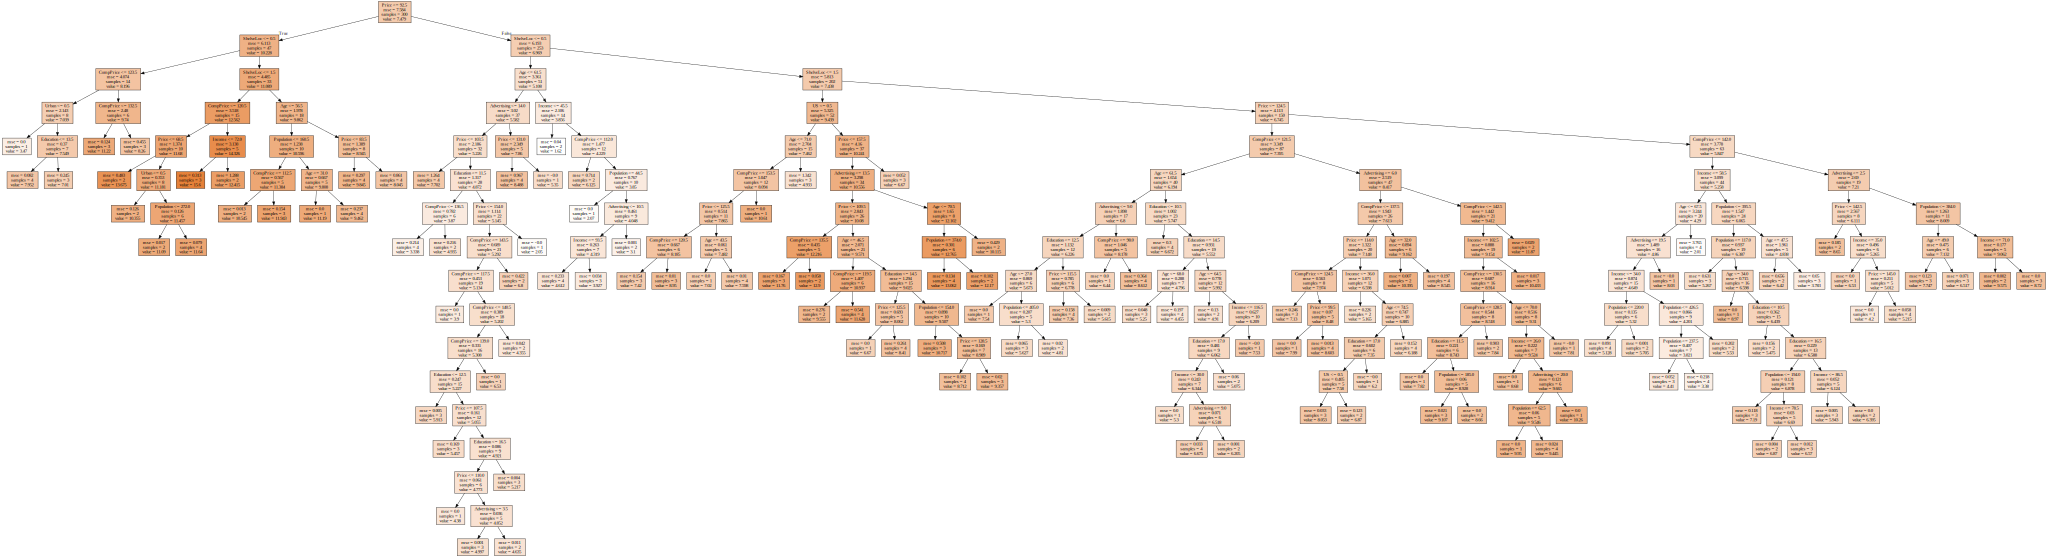

In [11]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG
graph = Source(tree.export_graphviz(reg_tree, out_file=None, filled=True, 
                                    feature_names=X.columns))
display(SVG(graph.pipe(format='svg')))

## c. CV Grid search for optimal regression tree

Currently `sklearn` doesn't implement cost complexity pruning (at the time of writing it is an [open issue on Github](https://github.com/scikit-learn/scikit-learn/issues/6557) and a [pending  pull request](https://github.com/scikit-learn/scikit-learn/pull/12887) may fix the issue.

In the meantime, [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) has many parameters one can vary for optimization. 
- `max_depth` -- the maximum depth of the tree.
- `min_samples_split` - The minimum number of samples required to split an internal node (this is a stopping criterion)
- `min_samples_leaf` - The minimum number of samples required to be at a leaf node.
- `max_leaf_nodes` - Grow a tree with max_leaf_nodes in best-first fashion.
- `min_impurity_decrease` - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

This is a lot of parameters, and there is bound to be some coflict and redundancy in a grid search. We'll make the parameter search a little faster with the following:
- Booth `min_samples_leaf` and `min_samples_split` are stopping criterion, but we'll go with `min_samples_split`, since it's a less restrictive criterion.
- Both `max_depth` and `max_leaf_nodes` both control tree depth, we'll choose `max_depth`, again since it's a less restrictive criterion. 

We would use a randomized search if the dataset were larger, but it's small enough we can do an exhaustive (grid) search.

We don't optimize `max_features` even though this would likely improve performance, since that is effectively a random forest with one tree and we'll be training a random forest model later in the exercise.

This [`sklearn` doc](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html) was helpful

In [12]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# parameter grid of size 1e3

depths = list(range(1, 10)) + [None]
sample_splits = list(range(2, 12))
impurity_decreases = np.linspace(0, 1, 10)

reg_tree_params = {'max_depth': depths, 
              'min_samples_split': sample_splits,
              'min_impurity_decrease': impurity_decreases}

# search best case 1/10 of parameter grid
reg_tree = DecisionTreeRegressor()
# use 6 fold CV because train size is 300
reg_tree_search = GridSearchCV(estimator=reg_tree,
                                param_grid=reg_tree_params,
                                cv=6,
                                scoring='neg_mean_squared_error')
%timeit -n1 -r1 reg_tree_search.fit(X_train, y_train)

28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
reg_tree_search.best_params_

{'max_depth': 8, 'min_impurity_decrease': 0.0, 'min_samples_split': 11}

In [14]:
# 6-fold cv estimate of test rmse
np.sqrt(-reg_tree_search.best_score_)

2.0189730868235154

In [15]:
from sklearn.metrics import mean_squared_error

# test set mse
final_reg_tree = reg_tree_search.best_estimator_
reg_tree_test_mse = mean_squared_error(final_reg_tree.predict(X_test), y_test)
np.sqrt(reg_tree_test_mse)

2.3843108670794915

## d. Bagged Regression Tree

In [16]:
from sklearn.ensemble import BaggingRegressor


bag_reg_params = {'n_estimators': np.arange(1, 100)}
bag_reg_tree = BaggingRegressor()

bag_reg_tree_search = GridSearchCV(estimator=bag_reg_tree,
                                   param_grid=bag_reg_params,
                                   cv=6,
                                   scoring='neg_mean_squared_error')

%timeit -n1 -r1 bag_reg_tree_search.fit(X_train, y_train)

44.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
bag_reg_tree_search.best_params_

{'n_estimators': 51}

In [18]:
# 6-fold cv estimate of test rmse
np.sqrt(-bag_reg_tree_search.best_score_)

1.6309302986679604

In [19]:
# test set mse
final_bag_reg_tree = bag_reg_tree_search.best_estimator_
bag_reg_tree_test_mse = mean_squared_error(final_bag_reg_tree.predict(X_test), y_test)
np.sqrt(bag_reg_tree_test_mse)

1.7220755952142313

## e. Random Forest

`sklearn`'s  `RandomForestRegressor` has a lot of parameters. We'll use a tactic borrowed from [this Medium article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) - randomized search to narrow down the range for the parameters, then grid search to fine-tune.



In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

random_forest_params = reg_tree_params
random_forest_params['max_features'] = np.arange(1, 10)
random_forest_params['n_estimators'] = np.arange(10, 100, 10)

random_forest = RandomForestRegressor()

# random search to narrow the parameter space
random_forest_rsearch = RandomizedSearchCV(estimator=random_forest,
                                   param_distributions=random_forest_params,
                                   n_iter=500,
                                   cv=6,
                                   scoring='neg_mean_squared_error',
                                   random_state=27)

%timeit -n1 -r1 random_forest_rsearch.fit(X_train, y_train)

2min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
random_forest_rsearch.best_params_

{'n_estimators': 60,
 'min_samples_split': 5,
 'min_impurity_decrease': 0.0,
 'max_features': 6,
 'max_depth': 9}

In [22]:
# grid search to fine tune
params = {'n_estimators': np.arange(31, 51, 2),
          'min_samples_split': [2, 3, 4, 5, 6],
          'min_impurity_decrease': [0.0, 1e-3, 1e-2],
          'max_features': [6, 7, 8, 9, 10] 
           }
random_forest_cvsearch = GridSearchCV(estimator=random_forest,
                                      param_grid=params,
                                      cv=6,
                                      scoring='neg_mean_squared_error')
%timeit -n1 -r1 random_forest_cvsearch.fit(X_train, y_train)

4min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
random_forest_cvsearch.best_params_

{'max_features': 8,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 2,
 'n_estimators': 43}

In [24]:
# 6-fold cv estimate of test rmse
np.sqrt(-random_forest_cvsearch.best_score_)

1.6234289198882141

In [25]:
# test set mse
final_random_forest = random_forest_cvsearch.best_estimator_
random_forest_test_mse = mean_squared_error(final_random_forest.predict(X_test), y_test)
np.sqrt(random_forest_test_mse)

1.712239660011634

In [26]:
# feature importances
rf_feat_imp = pd.DataFrame({'feature': X_train.columns, 
                            'importance': final_random_forest.feature_importances_})
rf_feat_imp.sort_values(by='importance', ascending=False)

,feature,importance
4,Price,0.337647
5,ShelveLoc,0.202521
0,CompPrice,0.132621
2,Advertising,0.097423
6,Age,0.088481
1,Income,0.054456
3,Population,0.037483
7,Education,0.028029
9,US,0.015726
8,Urban,0.005614
